In [1]:
### LIBRERÍAS

import os
import glob
import numpy as np
from tqdm import tqdm
from PIL import Image
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Paths

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
IMG_TRAIN_DIR = os.path.join(BASE_DIR, 'data', 'MASATI', 'output', 'train', 'images')
IMG_TEST_DIR = os.path.join(BASE_DIR, 'data', 'MASATI', 'output', 'test', 'images')
IMG_VAL_DIR = os.path.join(BASE_DIR, 'data', 'MASATI', 'output', 'val', 'images')
LBL_TRAIN_DIR = os.path.join(BASE_DIR, 'data', 'MASATI', 'output', 'train', 'labels')
LBL_TEST_DIR = os.path.join(BASE_DIR, 'data', 'MASATI', 'output', 'test', 'labels')
LBL_VAL_DIR = os.path.join(BASE_DIR, 'data', 'MASATI', 'output', 'val', 'labels')

# Análisis Exploratorio de Datos

In [3]:
print("Train images:", len(glob.glob(os.path.join(IMG_TRAIN_DIR, '*.png'))))
print("Validation images:", len(glob.glob(os.path.join(IMG_VAL_DIR, '*.png'))))
print("Test images:", len(glob.glob(os.path.join(IMG_TEST_DIR, '*.png'))))

Train images: 3617
Validation images: 452
Test images: 453


In [28]:
# las labels se encuentran dentro de archivos .txt, por lo que se debe leer cada archivo y extraer la información de las etiquetas
# el nombre del archivo de la imagen y el archivo de la etiqueta son iguales
# puede haber más de una etiqueta por imagen, por lo que se debe leer cada línea del archivo de etiquetas

def load_labels(label_dir):
    labels = []
    for label_file in tqdm(glob.glob(os.path.join(label_dir, '*.txt')), desc="Loading labels"):
        with open(label_file, 'r') as f:
            labels_img = [line.strip() for line in f if line.strip() != '']
            
        if labels_img:
            labels.append(labels_img)
    return labels

print("\nTRAINING")
labels_train = load_labels(LBL_TRAIN_DIR)
print("There are", len(labels_train), "images with boats")
print("The mean number of boats in those images is ", np.mean([len(l) for l in labels_train]))

print("\nVALIDATION")
labels_val = load_labels(LBL_VAL_DIR)
print("There are", len(labels_val), "images with boats")
print("The mean number of boats in those images is ", np.mean([len(l) for l in labels_val]))

print("\nTESTING")
labels_test = load_labels(LBL_TEST_DIR)
print("There are", len(labels_test), "images with boats")
print("The mean number of boats in those images is ", np.mean([len(l) for l in labels_test]))


TRAINING


Loading labels:   0%|          | 0/3617 [00:00<?, ?it/s]

Loading labels: 100%|██████████| 3617/3617 [00:00<00:00, 6904.93it/s]


There are 1888 images with boats
The mean number of boats in those images is  1.7309322033898304

VALIDATION


Loading labels: 100%|██████████| 452/452 [00:00<00:00, 6405.18it/s]


There are 237 images with boats
The mean number of boats in those images is  1.6160337552742616

TESTING


Loading labels: 100%|██████████| 453/453 [00:00<00:00, 7105.75it/s]

There are 243 images with boats
The mean number of boats in those images is  1.6584362139917694


La mitad de las imágenes no poseen barcos, pero las imágenes que sí tienen, pueden contener más de uno.

C:\Users\gonza\AppData\Local\Temp\ipykernel_6408\1436544970.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=num_barcos, palette='Set2')    # Una barra por cada valor distinto, con 20 colores distintos


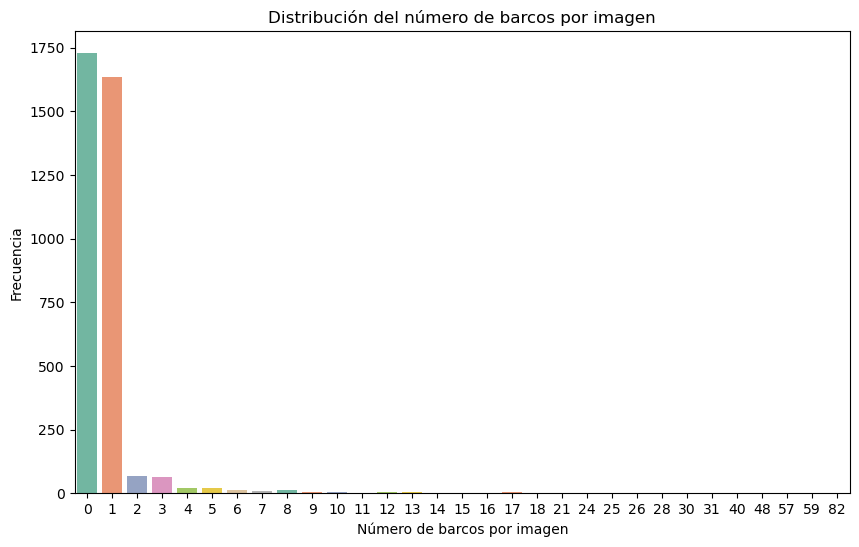

In [53]:

num_barcos = [len(l) for l in labels_train]
#añado las imagenes con 0 barcos
for i in range(len(labels_train), 3617):
    num_barcos.append(0)

# distribución del numero de barcos por imagen en train
plt.figure(figsize=(10, 6))
sns.countplot(x=num_barcos, palette='Set2')    # Una barra por cada valor distinto, con 20 colores distintos

plt.xlabel('Número de barcos por imagen')
plt.ylabel('Frecuencia')
plt.title('Distribución del número de barcos por imagen')
plt.show()


Existen imágenes con incluso 82 barcos, aunque vemos que la gran mayoría tienen uno o ninguno.

In [29]:
#leer clases de las etiquetas
def get_classes(labels):
    classes = set()
    for label in labels:
        for l in label:
            classes.add(l.split()[0])
    return list(classes)

classes_train = get_classes(labels_train)
classes_train


['0']

Solo hay una clase en el conjunto de datos, que corresponde a la detección de un barco.

Dimensiones de las imágenes:

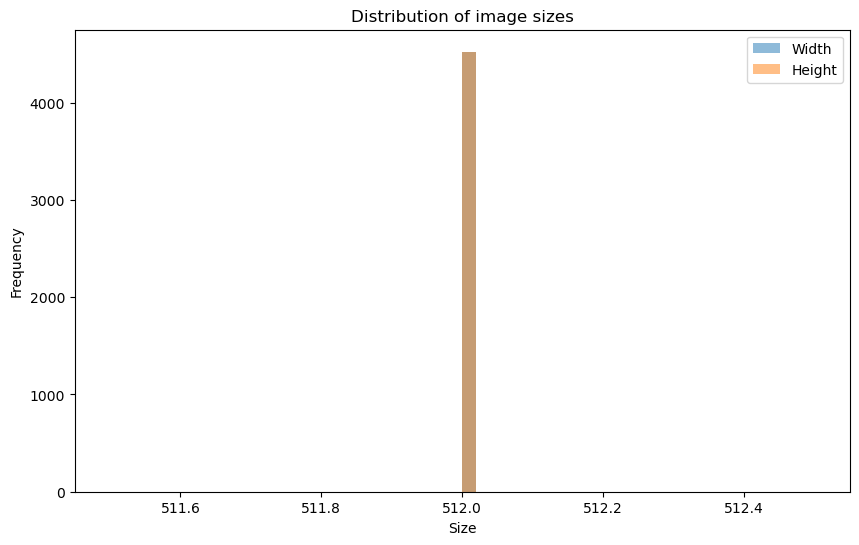

In [ ]:
#dimensiones de las imagenes   
def get_image_size(image_dir):
    sizes = []
    for img_file in glob.glob(os.path.join(image_dir, '*.png')):
        with Image.open(img_file) as img:
            sizes.append(img.size)
    return sizes

sizes_train = get_image_size(IMG_TRAIN_DIR)
sizes_val = get_image_size(IMG_VAL_DIR)
sizes_test = get_image_size(IMG_TEST_DIR)
sizes = sizes_train + sizes_val + sizes_test

#mostrar grafica de tamaños de imagenes de train, val y test
plt.figure(figsize=(10, 6))
plt.hist([s[0] for s in sizes], bins=50, alpha=0.5, label='Width')
plt.hist([s[1] for s in sizes], bins=50, alpha=0.5, label='Height')
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.title('Distribution of image sizes')
plt.legend()
plt.show()


Todas las imágenes son de 512 x 512 píxeles.

Histograma de colores y distribución de píxeles sobre una muestra de 400 imágenes, ya que el conjunto es bastante homogéneo en paleta de colores:

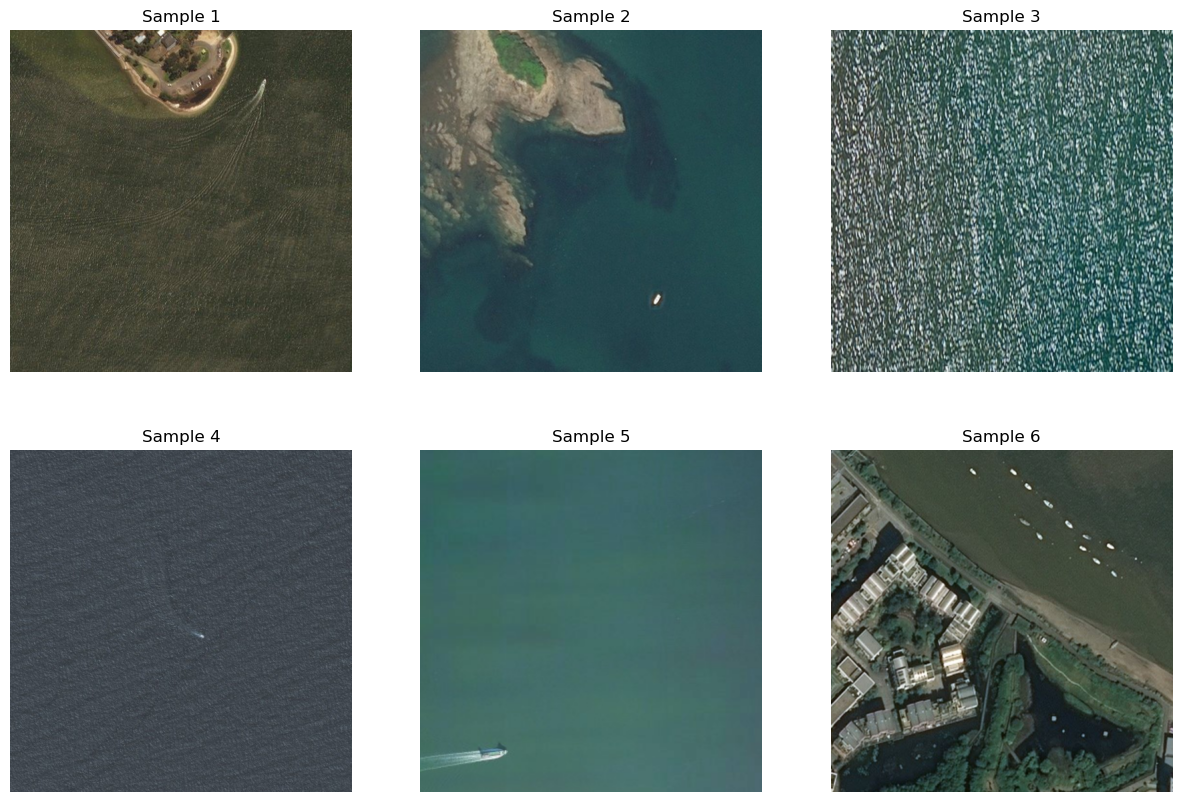

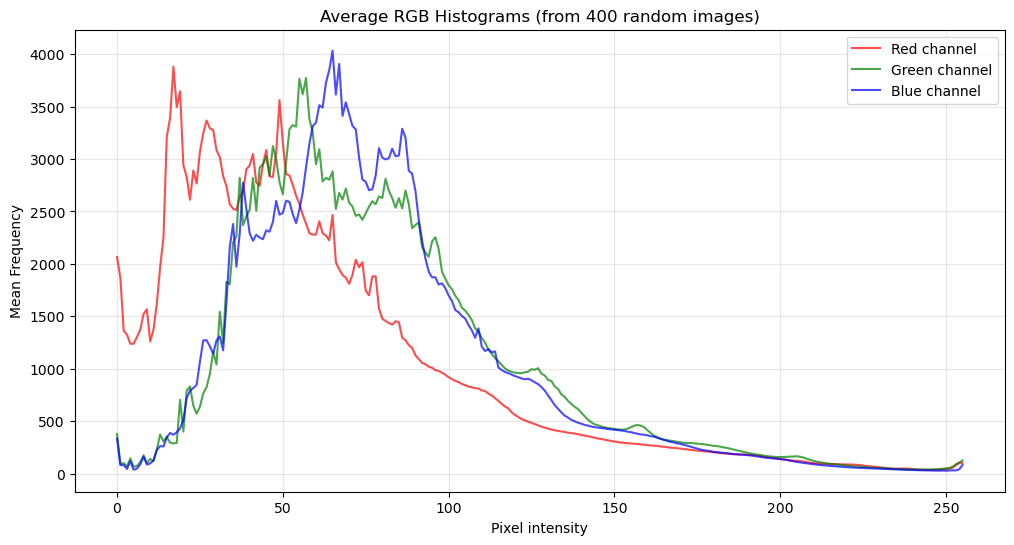

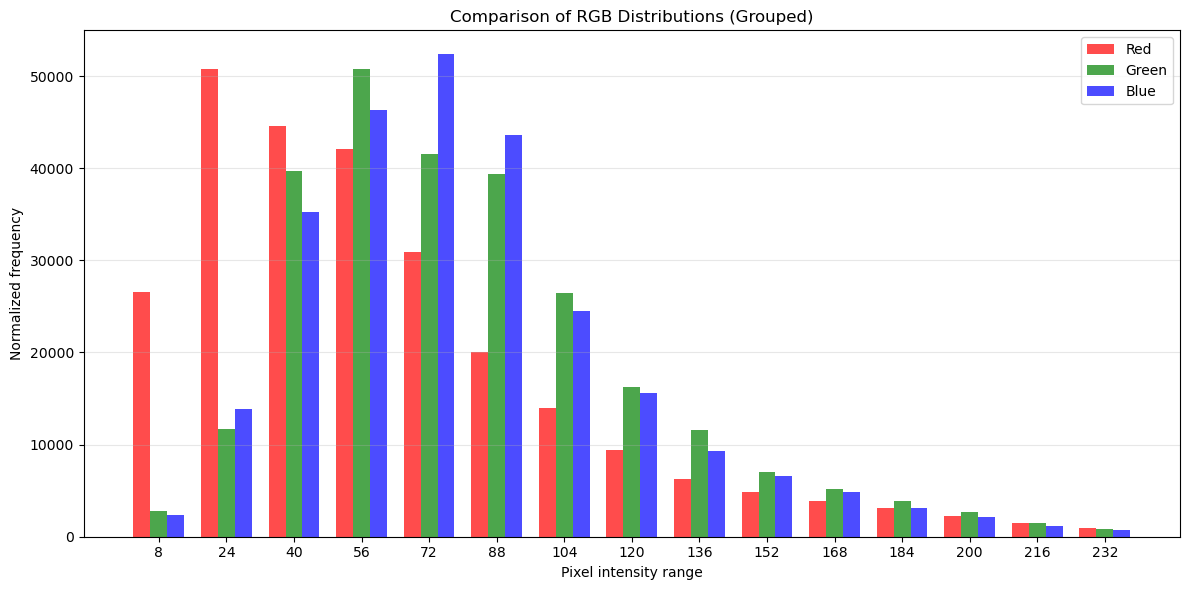

In [58]:
# Analysis of color histograms across the dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

# Select a random sample of images to analyze (analyzing all would be slow)
sample_size = 400
random_samples = random.sample(glob.glob(os.path.join(IMG_TRAIN_DIR, '*.png')), sample_size)

# Create histograms for RGB channels (cumulative across all images)
hist_r = np.zeros(256)
hist_g = np.zeros(256)
hist_b = np.zeros(256)

plt.figure(figsize=(15, 10))

# For displaying some sample images
plt.subplot(2, 3, 1)
plt.title("Sample Images")
sample_images = []

for i, img_path in enumerate(random_samples):
    # Read image
    img = np.array(Image.open(img_path))
    
    # For first few images, display them as samples
    if i < 6:
        sample_images.append(img)
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Sample {i+1}")
    
    # Check if the image is grayscale (2D) or color (3D)
    if len(img.shape) == 3 and img.shape[2] >= 3:
        # Extract RGB channels
        r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
        
        # Update histograms
        hist_r += np.histogram(r, bins=256, range=(0, 256))[0]
        hist_g += np.histogram(g, bins=256, range=(0, 256))[0]
        hist_b += np.histogram(b, bins=256, range=(0, 256))[0]
    elif len(img.shape) == 2:
        # For grayscale images, update all channels with the same values
        hist_gray = np.histogram(img, bins=256, range=(0, 256))[0]
        hist_r += hist_gray
        hist_g += hist_gray
        hist_b += hist_gray

# Normalize histograms
hist_r = hist_r / sample_size
hist_g = hist_g / sample_size
hist_b = hist_b / sample_size

# Plot combined histogram
plt.figure(figsize=(12, 6))
plt.plot(hist_r, color='red', alpha=0.7, label='Red channel')
plt.plot(hist_g, color='green', alpha=0.7, label='Green channel')
plt.plot(hist_b, color='blue', alpha=0.7, label='Blue channel')
plt.xlabel('Pixel intensity')
plt.ylabel('Mean Frequency')
plt.title(f'Average RGB Histograms (from {sample_size} random images)')
plt.legend()
plt.grid(alpha=0.3)

# Also show RGB distribution as bar chart for easier comparison
plt.figure(figsize=(12, 6))
bin_edges = np.arange(0, 256, 16)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
width = 4

# Group histogram values into bins for bar chart
def bin_hist(hist, edges):
    return np.array([hist[edges[i]:edges[i+1]].sum() for i in range(len(edges)-1)])

hist_r_binned = bin_hist(hist_r, bin_edges)
hist_g_binned = bin_hist(hist_g, bin_edges)
hist_b_binned = bin_hist(hist_b, bin_edges)

plt.bar(bin_centers - width, hist_r_binned, width=width, color='red', alpha=0.7, label='Red')
plt.bar(bin_centers, hist_g_binned, width=width, color='green', alpha=0.7, label='Green')
plt.bar(bin_centers + width, hist_b_binned, width=width, color='blue', alpha=0.7, label='Blue')
plt.xlabel('Pixel intensity range')
plt.ylabel('Normalized frequency')
plt.title('Comparison of RGB Distributions (Grouped)')
plt.legend()
plt.xticks(bin_centers)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Con intensidades grandes, vemos que prevalecen los colores azul y verde, lo que es lógico ya que las imágenes son de barcos en el mar.

# MACHINE LEARNING (CLASIFICACIÓN)

En primer lugar ajustaremos un modelo de machine learning (SVM) para hacer una clasificación binaria y está basado en la extracción de características HOG. Es decir, el objetivo es determinar si una foto tiene barco o no. En un primer momento, es de suponer que deste no debería ser un muy buen modelo, ya que no se está usando ningún método de deep learning para esta clasificación.

In [3]:
# Función para saber si hay barco
def has_boat(label_path):
    return os.path.exists(label_path) and os.path.getsize(label_path) > 0

# Extraer características HOG usando Pillow
def extract_features(image_path):
    image = Image.open(image_path).convert("L")  # Convertir a escala de grises
    image = image.resize((128, 128))  # Redimensionar
    image_np = np.array(image)

    features, _ = hog(image_np,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      visualize=True)
    return features

In [4]:
# Cargar imágenes de entrenamiento
X_train, y_train = [], []
train_image_paths = glob.glob(os.path.join(IMG_TRAIN_DIR, '*.png'))

for img_path in tqdm(train_image_paths, desc="Extrayendo características de entrenamiento"):
    filename = os.path.splitext(os.path.basename(img_path))[0] + '.txt'
    label_path = os.path.join(LBL_TRAIN_DIR, filename)  # Ruta de etiquetas de entrenamiento

    label = int(has_boat(label_path))
    features = extract_features(img_path)

    X_train.append(features)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Cargar imágenes de prueba
X_test, y_test = [], []
test_image_paths = glob.glob(os.path.join(IMG_TEST_DIR, '*.png'))

for img_path in tqdm(test_image_paths, desc="Extrayendo características de test"):
    filename = os.path.splitext(os.path.basename(img_path))[0] + '.txt'
    label_path = os.path.join(LBL_TEST_DIR, filename)  # Ruta de etiquetas de prueba

    label = int(has_boat(label_path))  
    features = extract_features(img_path)

    X_test.append(features)
    y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

Extrayendo características de test: 100%|████████████████████████████████████████████| 453/453 [00:48<00:00,  9.31it/s]


In [5]:
# Modelo
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)

# Evaluación en conjunto de prueba
y_pred = model.predict(X_test)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=["No barco", "Barco"]))


Reporte de clasificación:
              precision    recall  f1-score   support

    No barco       0.58      0.57      0.57       210
       Barco       0.63      0.64      0.64       243

    accuracy                           0.61       453
   macro avg       0.60      0.60      0.60       453
weighted avg       0.61      0.61      0.61       453



Obtenemos un accurcay del 61%, un poco más del 50% que sería puro azar, por lo tanto confirmamos nuestras primeras sospechas de que un método de machine learning no es el más adecuado para esta tarea.

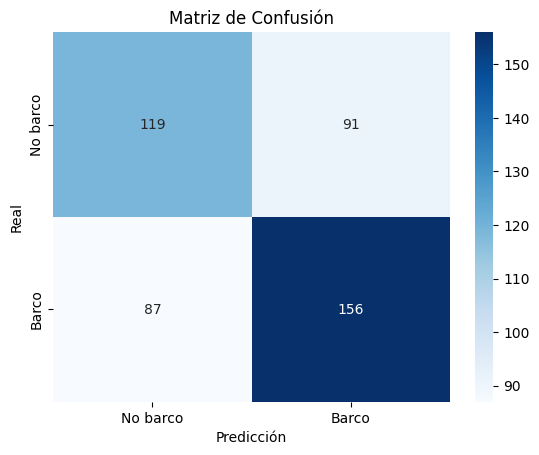

In [6]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No barco", "Barco"], yticklabels=["No barco", "Barco"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# DEEP LEARNING (CLASIFICACIÓN)

Ahora ajustaremos un modelo de deep learning (una CNN) y veremos si ofrece mejores resultados que el modelo anterior, lo cual es de esperar.

In [3]:
IMG_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class BoatDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, '*.png')))
        self.label_dir = label_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def has_boat(self, label_path):
        if not os.path.exists(label_path):
            return 0
        with open(label_path, 'r') as f:
            return int(bool(f.read().strip()))

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        filename = os.path.splitext(os.path.basename(img_path))[0] + '.txt'
        label_path = os.path.join(self.label_dir, filename)

        image = Image.open(img_path).convert('RGB')
        label = self.has_boat(label_path)

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# Cargamos los datasets de train, validation y test
train_dataset = BoatDataset(IMG_TRAIN_DIR, LBL_TRAIN_DIR, transform)
val_dataset = BoatDataset(IMG_VAL_DIR, LBL_VAL_DIR, transform)
test_dataset = BoatDataset(IMG_TEST_DIR, LBL_TEST_DIR, transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [14]:
class ImprovedBoatClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1)


In [15]:
# Inicializar listas para guardar métricas
train_losses = []
train_accuracies = []

# Entrenamos la CNN
model = ImprovedBoatClassifier().to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.float().to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images).view(-1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        predictions = (outputs > 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")


Epoch 1/15, Loss: 0.6610, Accuracy: 0.5964
Epoch 2/15, Loss: 0.6304, Accuracy: 0.6417
Epoch 3/15, Loss: 0.6196, Accuracy: 0.6563
Epoch 4/15, Loss: 0.6060, Accuracy: 0.6605
Epoch 5/15, Loss: 0.5928, Accuracy: 0.6718
Epoch 6/15, Loss: 0.5771, Accuracy: 0.6879
Epoch 7/15, Loss: 0.5542, Accuracy: 0.7000
Epoch 8/15, Loss: 0.5265, Accuracy: 0.7230
Epoch 9/15, Loss: 0.4789, Accuracy: 0.7597
Epoch 10/15, Loss: 0.4339, Accuracy: 0.7935
Epoch 11/15, Loss: 0.3763, Accuracy: 0.8233
Epoch 12/15, Loss: 0.3314, Accuracy: 0.8537
Epoch 13/15, Loss: 0.2756, Accuracy: 0.8808
Epoch 14/15, Loss: 0.2422, Accuracy: 0.8974
Epoch 15/15, Loss: 0.2001, Accuracy: 0.9165


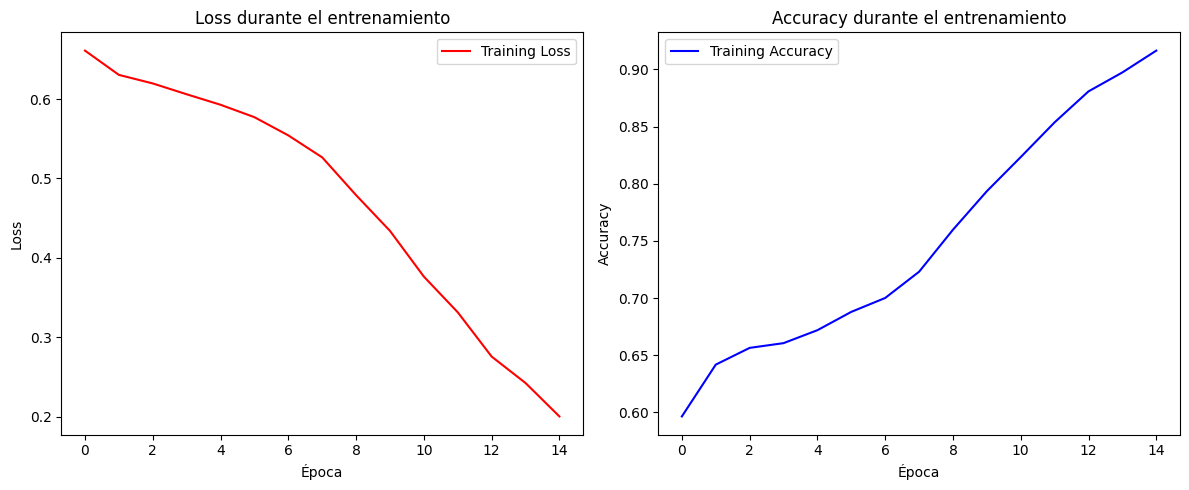

In [16]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='red')
plt.title('Loss durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Vemos como el loss va decayendo a lo largo de las épocas, mientras que el accuracy va en aumento. El entrenamiento concluye con un training accuracy del 91%. Este modelo fue entrenado mediante cross-validation con un grid de hiperparámetros, pero debido al tiempo que requería se optó por poner directamente el mejor resultado.

In [17]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        preds = (outputs > 0.5).int().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=['No Boat', 'Boat']))


              precision    recall  f1-score   support

     No Boat       0.75      0.83      0.79       210
        Boat       0.84      0.76      0.80       243

    accuracy                           0.79       453
   macro avg       0.79      0.80      0.79       453
weighted avg       0.80      0.79      0.79       453



Aquí observamos que tenemos un 79% de accuracy en test, por lo que podríamos argumentar que sí existe un ligero sobreaprendizaje. Así y todo, este fue le mejor modelo que pudimos obtener usando una CNN.

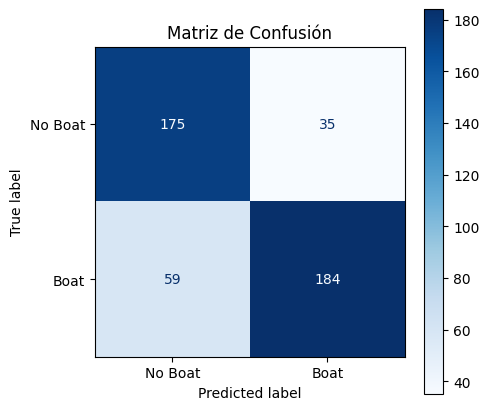

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Boat', 'Boat'])

# Visualización
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Matriz de Confusión")
plt.show()

# DEEP LEARNING: YOLO (DETECCIÓN)

You Only Look Once (YOLO) es un algoritmo de detección de objetos en imágenes. A diferencia de otros métodos que analizan la imagen en varias etapas, YOLO trata la detección como un problema de regresión único, lo que lo hace más rápido y eficiente.

Existen múltiples versiones de YOLO, cada una mejorando la precisión y velocidad del modelo. Se usará YOLO v8 y YOLO v11 en los formatos más pequeños, que son más rápidos y ligeros, pero con una precisión ligeramente inferior: los modelos YOLOv8n y YOLOv11n.

In [12]:
from ultralytics import YOLO
import torch
import cv2

YAML_DATA = os.path.join(BASE_DIR, 'data', 'data.yaml')

In [9]:
# gpu o cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


Carga del modelo YOLO v8 preentrenado. Este modelo ha sido entrenado en el conjunto de datos COCO, que contiene 80 clases de objetos. Se realizará un ajuste fino (fine-tuning) del modelo para adaptarlo a nuestro conjunto de datos específico, que solo tiene una clase: barco.

In [7]:
model = YOLO('yolov8n.pt') # modelo mas pequeño

## Primer entrenamiento

In [1]:
YAML_DATA = os.path.join(BASE_DIR, 'data', 'data.yaml')

# Ajuste los hiperparámetros y entrenamiento del modelo
#    - data: data.yaml
#    - epochs: nº de épocas 
#    - imgsz: tamaño de lado de las imágenes 
#    - batch: tamaño de lote 
#    - device: GPU o CPU
model.train(
    data=YAML_DATA,
    epochs=50,
    imgsz=512,
    batch=32,
    device=device,
    name='first-boat-detection',
)

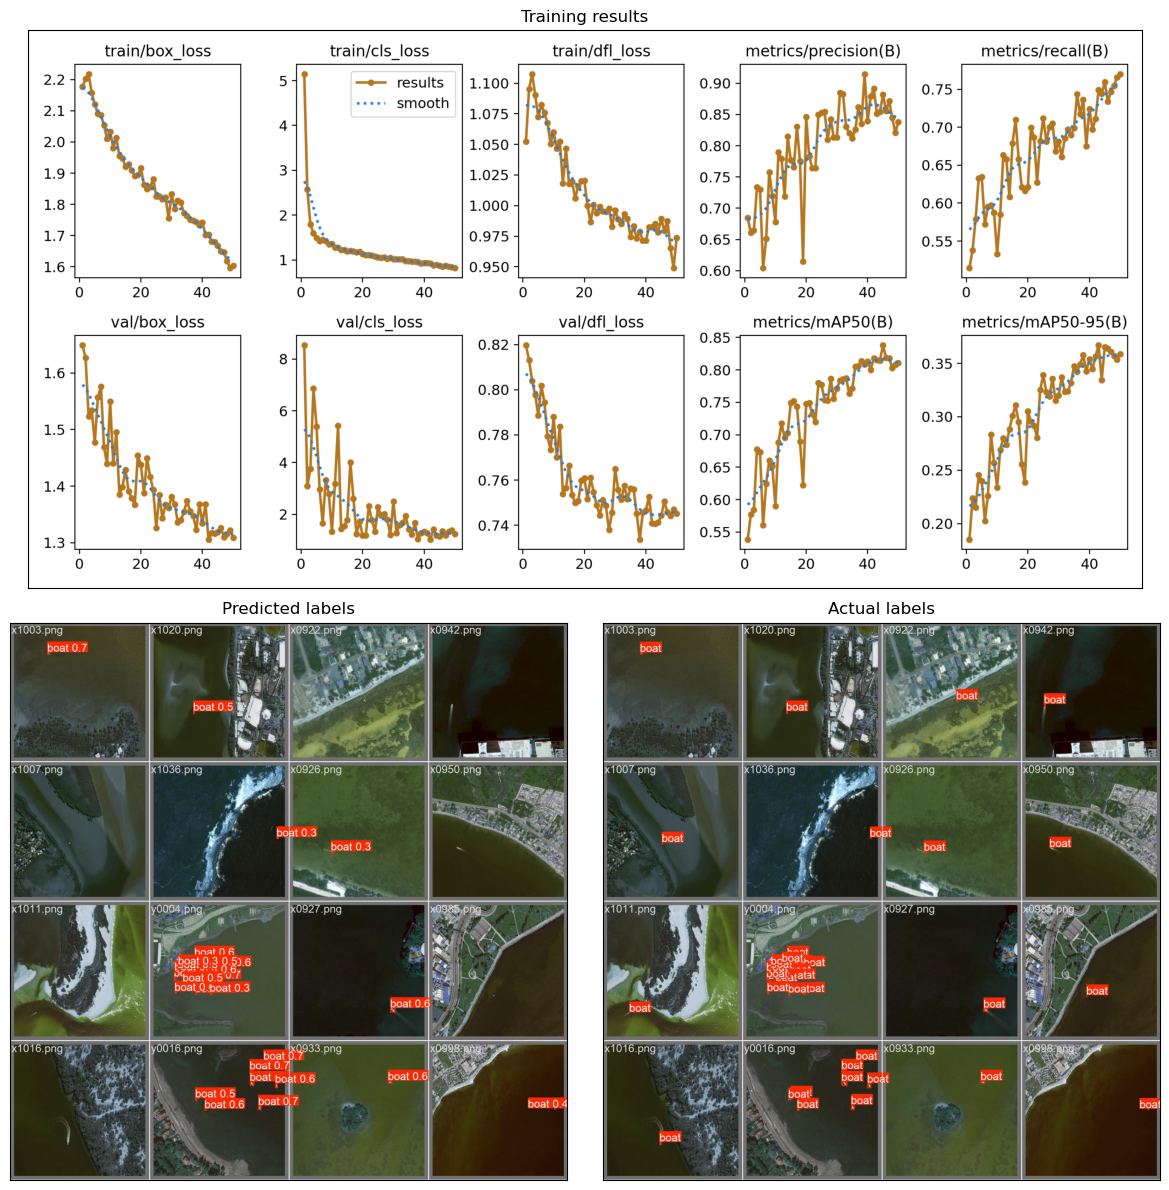

In [6]:
import matplotlib.pyplot as plt 
import cv2 as cv

train_dir = 'first-boat-detection'

results = cv.imread(f'runs/detect/{train_dir}/results.png')
val_pred = cv.imread(f'runs/detect/{train_dir}/val_batch0_pred.jpg')
val_labels = cv.imread(f'runs/detect/{train_dir}/val_batch0_labels.jpg')
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, :])  
ax1.set_title('Training results')
ax1.imshow(results)
ax1.set_xticks([]) 
ax1.set_yticks([]) 

ax2 = fig.add_subplot(gs[1, 0])  
ax2.set_title('Predicted labels')
ax2.imshow(val_pred)
ax2.set_xticks([]) 
ax2.set_yticks([]) 

ax3 = fig.add_subplot(gs[1, 1])  
ax3.set_title('Actual labels')
ax3.imshow(val_labels)
ax3.set_xticks([]) 
ax3.set_yticks([]) 

plt.tight_layout()
plt.show()

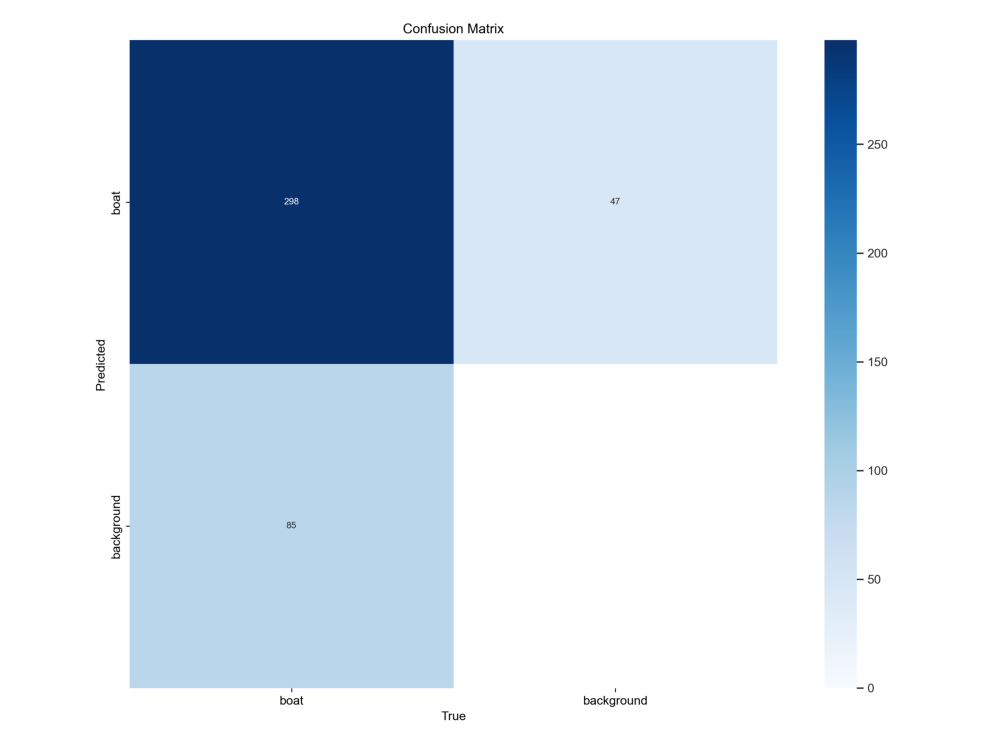

In [22]:
from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the confusion matrix image
img = mpimg.imread('runs/detect/first-boat-detection/confusion_matrix.png')

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.tight_layout()
plt.show()

Las gráficas del entrenamiento detalladas se encuentran en el directorio code/runs/detect/first-boat-detection

### Evaluación del modelo
Vamos a ver como se comporta con los datos de test.

In [10]:
path_modelo = os.path.join(BASE_DIR, 'code/runs/detect/first-boat-detection/weights/best.pt')
# Evaluación del modelo con imagenes de test
model = YOLO(path_modelo)


image 1/1 c:\Users\gonza\Desktop\ImagenADNE\DeepLearning-Images\data\MASATI\output\test\images\x0099.png: 512x512 1 boat, 14.7ms
Speed: 4.1ms preprocess, 14.7ms inference, 247.7ms postprocess per image at shape (1, 3, 512, 512)


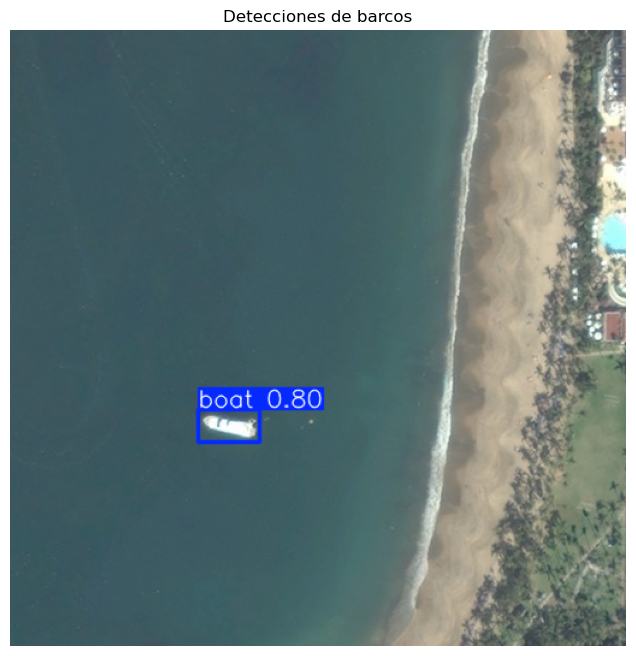

Tiempo de inferencia: 14.73 ms


In [11]:
#probar con una imagen de test y mostrar imagen
img_path = os.path.join(IMG_TEST_DIR, 'x0099.png')
results = model.predict(img_path, conf=0.5, iou=0.5, device=device)

# Obtener la imagen con los bounding boxes ya dibujados
annotated_img = results[0].plot()

# Convertir de BGR (OpenCV) a RGB (matplotlib)
annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

# Mostrar la imagen en el notebook
plt.figure(figsize=(12, 8))
plt.imshow(annotated_img_rgb)
plt.title("Detecciones de barcos")
plt.axis('off')
plt.show()

print(f"Tiempo de inferencia: {results[0].speed['inference']:.2f} ms")

Velocidad de inferencia extremadamente rápida, prácticamente 2 centésimas de segundo usando GPU.

### mAP en el conjunto de test

Vamos a medir el mAP del modelo, que es la métrica más comúnmente usada para evaluar modelos de detección de objetos. El mAP se calcula como el promedio de la precisión media (AP) en diferentes IoU (Intersection over Union) umbrales.

Así compararemos el rendimiento de este modelo con los siguientes.

In [3]:
# aplicar modelo a todo el conjunto de test, que tiene labels para comprobar los aciertos
metrics = model.val(
    data=YAML_DATA,
    split='test',
    device=device,
    iou=0.50,          # IoU mínimo para contar TP/FP
    conf=0.3,        # umbral mínimo de confianza para considerarlo detección
    save=False
)

In [24]:
print("mAP@0.5:",    metrics.box.map50)

mAP@0.5: 0.8120662876115152


##  Mejora del entrenamiento
Modificando ligeramente hiperparámetros (lr, warmup, momentum, lr scheduling) y haciendo uso de técnicas de data augmentation, se realiza un segundo entrenamiento del modelo. Se han añadido técnicas como rotación, cambio de brillo y contraste, entre otras, gracias al parámetro auto_augment. Para nuestro dataset de imágenes satelitales, todo esto permitirá aumentar la robustez.


In [5]:
model.train(
    task='detect',
    mode='train',
    model='yolov8n.pt',
    data=r'c:\Users\gonza\Desktop\ImagenADNE\DeepLearning-Images\data\data.yaml',
    epochs=50,                
    batch=16,
    imgsz=512,
    device=device,
    single_cls=True,           # solo una clase (barco)
    patience=10,               # early-stop tras 10 epochs sin mejora
    save=True,
    save_period=1,             # guarda pesos cada epoch
    optimizer='SGD',           # SGD suele dar mejor generalización en Nano
    lr0=0.005,                  # lr inicial algo más bajo
    lrf=0.1,                    # lr final = 0.1 * lr0
    momentum=0.9,
    weight_decay=0.0005,
    warmup_epochs=3.0,
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,
    cos_lr=True,               # Cosine LR schedule
    amp=True,                  # Mixed Precision
    half=True,                 # FP16
    augment=True,
    mosaic=1.0,                # siempre mosaic
    mixup=0.2,                 # 20% mixup
    copy_paste=0.2,            # 20% copy-paste
    auto_augment='randaugment',
    multi_scale=True,          # escala variable
    name='boat-nano-optimized'
)

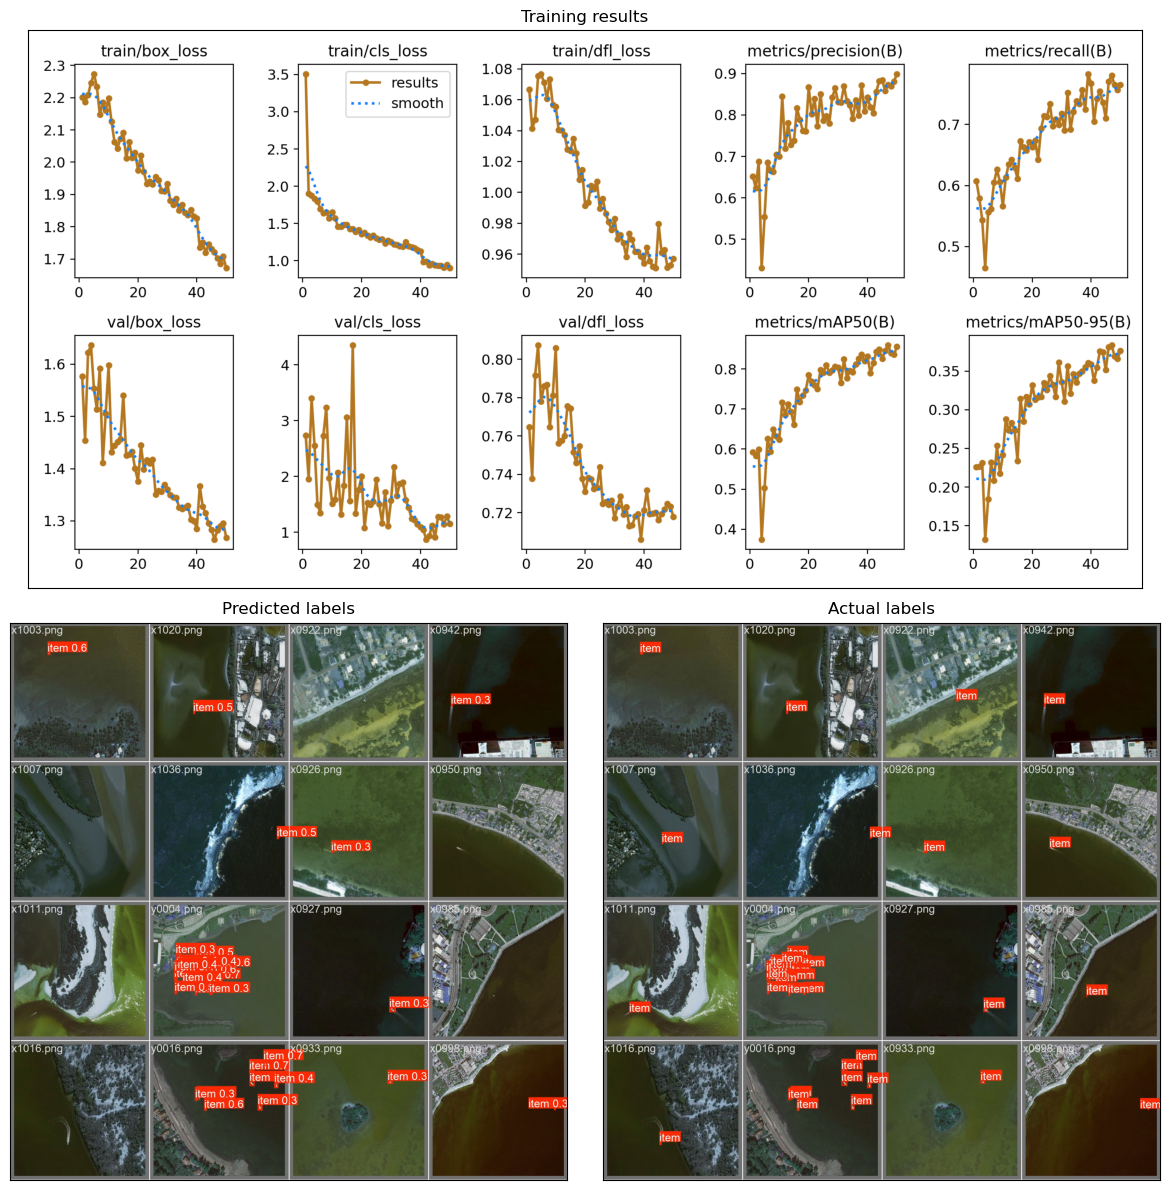

In [5]:
import matplotlib.pyplot as plt 
import cv2 as cv

train_dir = 'boat-nano-optimized'

results = cv.imread(f'runs/detect/{train_dir}/results.png')
val_pred = cv.imread(f'runs/detect/{train_dir}/val_batch0_pred.jpg')
val_labels = cv.imread(f'runs/detect/{train_dir}/val_batch0_labels.jpg')
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, :])  
ax1.set_title('Training results')
ax1.imshow(results)
ax1.set_xticks([]) 
ax1.set_yticks([]) 

ax2 = fig.add_subplot(gs[1, 0])  
ax2.set_title('Predicted labels')
ax2.imshow(val_pred)
ax2.set_xticks([]) 
ax2.set_yticks([]) 

ax3 = fig.add_subplot(gs[1, 1])  
ax3.set_title('Actual labels')
ax3.imshow(val_labels)
ax3.set_xticks([]) 
ax3.set_yticks([]) 

plt.tight_layout()
plt.show()

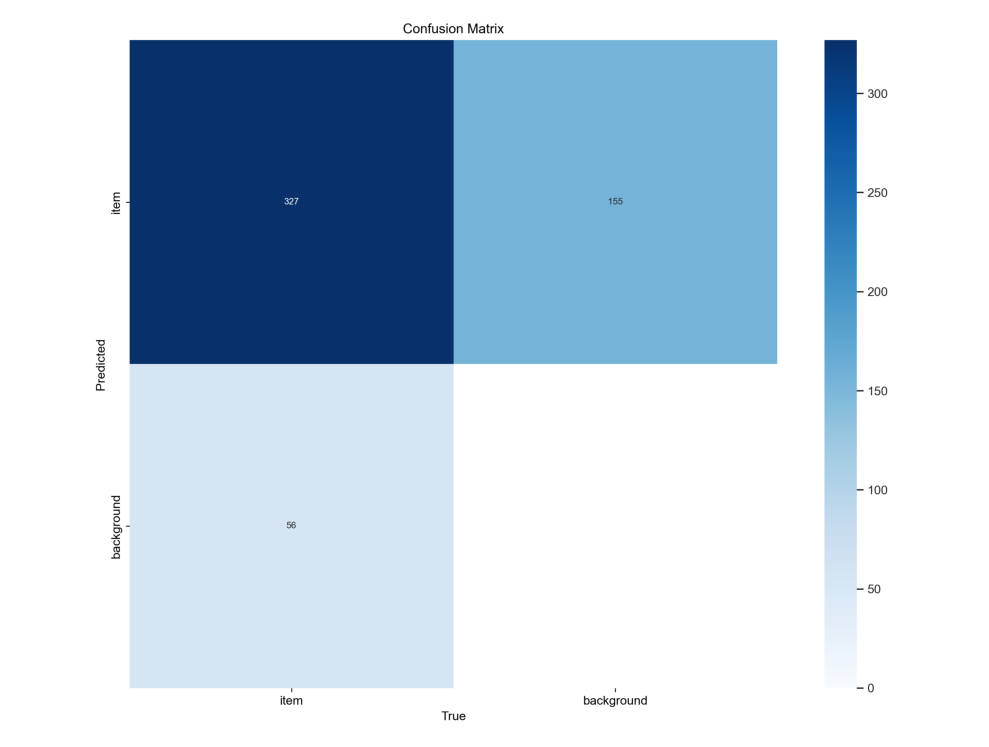

In [ ]:
# Load the confusion matrix image
img = mpimg.imread('runs/detect/boat-nano-optimized/confusion_matrix.png')

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.tight_layout()
plt.show()

### mAP en el conjunto de test

In [25]:
path_modelo = os.path.join(BASE_DIR, 'code/runs/detect/boat-nano-optimized/weights/best.pt')
model = YOLO(path_modelo)

In [7]:
# aplicar modelo a todo el conjunto de test, que tiene labels para comprobar los aciertos
metrics2 = model.val(
    data=YAML_DATA,
    split='test',
    device=device,
    iou=0.50,          # IoU mínimo para contar TP/FP
    conf=0.3,        # umbral mínimo de confianza para considerarlo detección
    save=False
)

In [29]:
print("mAP@0.5: ", metrics2.box.map50)

mAP@0.5:  0.8210698393237044


## YOLOv11

Esta es la versión más reciente de YOLO con un buen soporte de la comunidad y facilidad de uso, así que se probará un último entrenamiento con esta versión, también con el modelo nano, que es más ligero y rápido.

In [6]:
# yolov11 nano
model = YOLO('yolo11n.pt')

In [9]:
YAML_DATA = os.path.join(BASE_DIR, 'data', 'data.yaml')

model.train(
    data=YAML_DATA,
    epochs=60,
    imgsz=512,
    device=device,
    name='yolov11-nano-boat-detection',
    augment=True,
    single_cls=True
)

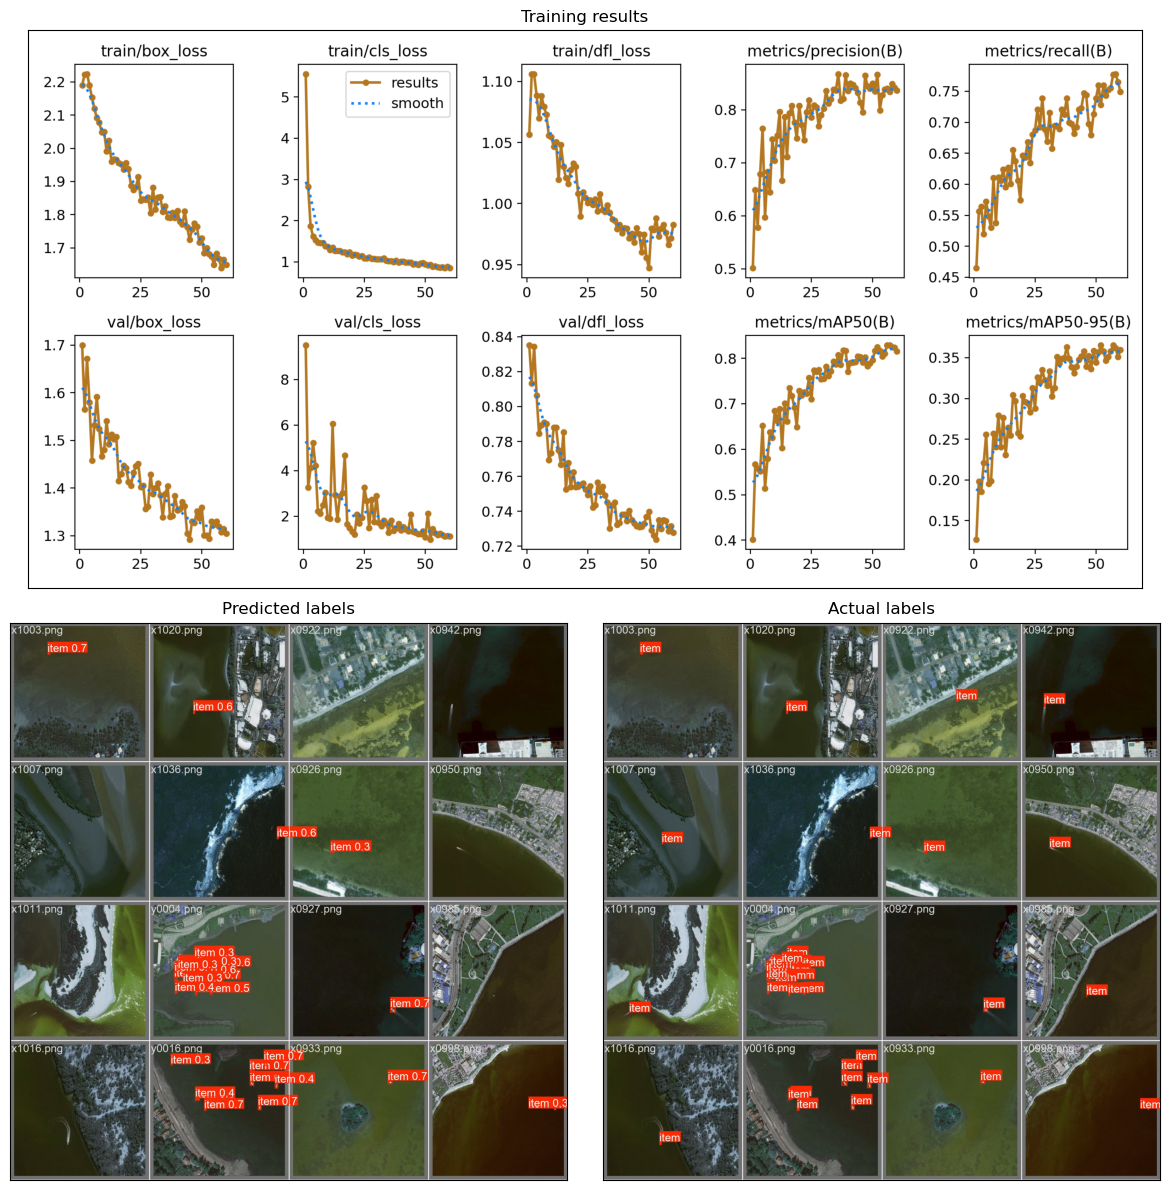

In [4]:
import matplotlib.pyplot as plt 
import cv2 as cv

train_dir = 'yolov11-nano-boat-detection'

results = cv.imread(f'runs/detect/{train_dir}/results.png')
val_pred = cv.imread(f'runs/detect/{train_dir}/val_batch0_pred.jpg')
val_labels = cv.imread(f'runs/detect/{train_dir}/val_batch0_labels.jpg')
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, :])  
ax1.set_title('Training results')
ax1.imshow(results)
ax1.set_xticks([]) 
ax1.set_yticks([]) 

ax2 = fig.add_subplot(gs[1, 0])  
ax2.set_title('Predicted labels')
ax2.imshow(val_pred)
ax2.set_xticks([]) 
ax2.set_yticks([]) 

ax3 = fig.add_subplot(gs[1, 1])  
ax3.set_title('Actual labels')
ax3.imshow(val_labels)
ax3.set_xticks([]) 
ax3.set_yticks([]) 

plt.tight_layout()
plt.show()

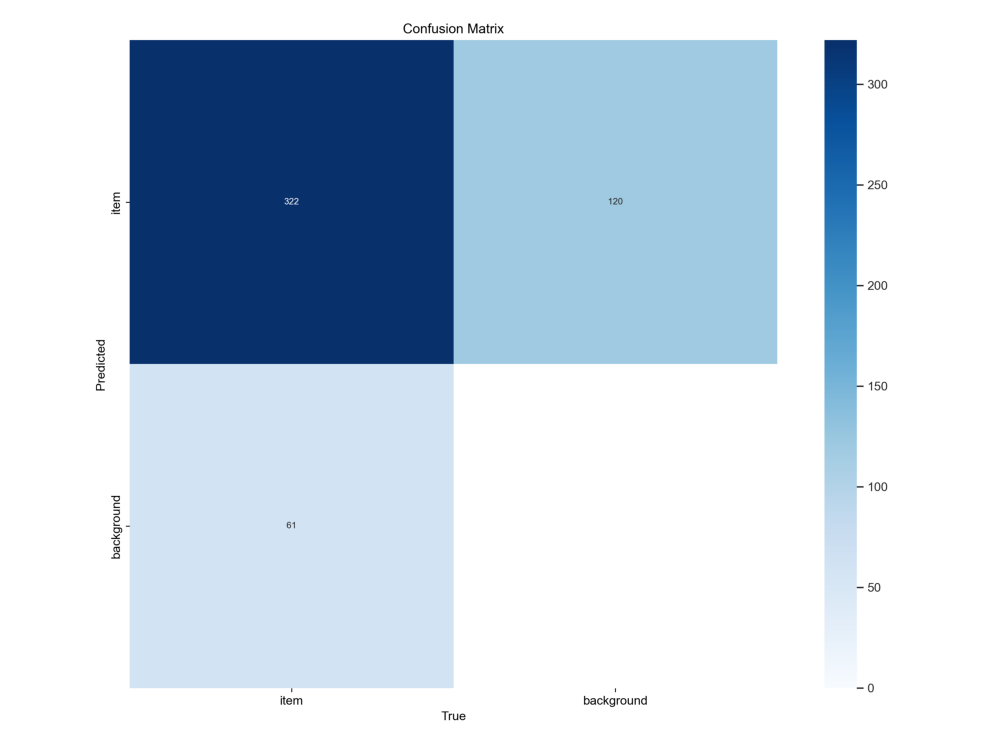

In [23]:
# Load the confusion matrix image
img = mpimg.imread('runs/detect/yolov11-nano-boat-detection/confusion_matrix.png')

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.tight_layout()
plt.show()

### mAP en el conjunto de test

In [30]:
path_modelo = os.path.join(BASE_DIR, 'code/runs/detect/yolov11-nano-boat-detection/weights/best.pt')
model = YOLO(path_modelo)

In [11]:
# aplicar modelo a todo el conjunto de test, que tiene labels para comprobar los aciertos
metrics2 = model.val(
    data=YAML_DATA,
    split='test',
    device=device,
    iou=0.50,          # IoU mínimo para contar TP/FP
    conf=0.3,        # umbral mínimo de confianza para considerarlo detección
    save=False
)

In [32]:
print("mAP@0.5: ", metrics2.box.map50)

mAP@0.5:  0.8128365023843663


## Mejor modelo YOLO: yolov8 nano con finetuning optimizado

Alcanzó el mayor mAP en el conjunto de test, 0.82. 

# Generación de imágenes

Se usará un AutoEncoder para generar imágenes sintéticas. Un AutoEncoder es una red neuronal que aprende a codificar y decodificar datos, permitiendo la generación de nuevas muestras similares a las originales.

Entrenando...
Epoch 1/20 - Loss: 0.0068
Epoch 2/20 - Loss: 0.0065
Epoch 3/20 - Loss: 0.0030
Epoch 4/20 - Loss: 0.0041
Epoch 5/20 - Loss: 0.0055
Epoch 6/20 - Loss: 0.0027
Epoch 7/20 - Loss: 0.0023
Epoch 8/20 - Loss: 0.0054
Epoch 9/20 - Loss: 0.0030
Epoch 10/20 - Loss: 0.0030
Epoch 11/20 - Loss: 0.0036
Epoch 12/20 - Loss: 0.0041
Epoch 13/20 - Loss: 0.0034
Epoch 14/20 - Loss: 0.0040
Epoch 15/20 - Loss: 0.0065
Epoch 16/20 - Loss: 0.0045
Epoch 17/20 - Loss: 0.0057
Epoch 18/20 - Loss: 0.0031
Epoch 19/20 - Loss: 0.0057
Epoch 20/20 - Loss: 0.0057
Generando imágenes nuevas...


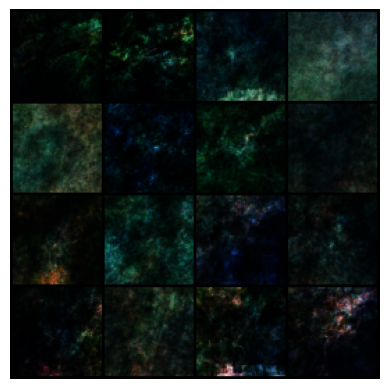

In [3]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

# === CONFIGURACIÓN ===
IMAGE_DIR = os.path.join(BASE_DIR, 'data', 'generacion')
BATCH_SIZE = 16
EPOCHS = 20
LATENT_DIM = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# === PREPROCESAMIENTO ===
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(
    root=os.path.dirname(IMAGE_DIR), 
    transform=transform
)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# === DEFINICIÓN AUTOENCODER ===
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 64 * 3, 1024),
            nn.ReLU(),
            nn.Linear(1024, LATENT_DIM)
        )
        self.decoder = nn.Sequential(
            nn.Linear(LATENT_DIM, 1024),
            nn.ReLU(),
            nn.Linear(1024, 64 * 64 * 3),
            nn.Sigmoid(),
            nn.Unflatten(1, (3, 64, 64))
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

model = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# === ENTRENAMIENTO ===
print("Entrenando...")
for epoch in range(EPOCHS):
    for imgs, _ in dataloader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        loss = loss_fn(outputs, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {loss.item():.4f}")

# === GENERAR IMÁGENES NUEVAS ===
print("Generando imágenes nuevas...")
with torch.no_grad():
    z = torch.randn(16, LATENT_DIM).to(DEVICE)
    generated = model.decoder(z)

# === MOSTRAR RESULTADO ===
utils.save_image(generated, "imagenes_generadas.png", nrow=4)
plt.imshow(plt.imread("imagenes_generadas.png"))
plt.axis("off")
plt.show()

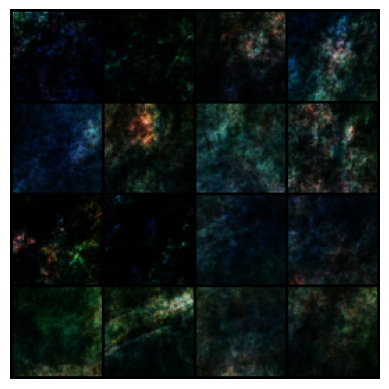

In [32]:
with torch.no_grad():
    z = torch.randn(16, LATENT_DIM).to(DEVICE)
    generated = model.decoder(z)
    
utils.save_image(generated, "imagenes_generadas.png", nrow=4)
plt.imshow(plt.imread("imagenes_generadas.png"))
plt.axis("off")
plt.show()

Como se aprecia en la imagen, el autoencoder ha sido capaz de aprender a generar imágenes del mar, aunque a muy baja resolución (64 x 64 píxeles). 

Un aspecto a mejorar es el pequeño número de imágenes que se usaron para el entrenamiento, ya que el autoencoder necesita un gran número de imágenes para aprender a generar imágenes realistas. En este caso, se usaron 30 imágenes, lo que es muy poco.
Esto se debe a las limitaciones de tiempo y recursos, pero en un caso real se podría usar un conjunto de datos más grande para obtener mejores resultados.